Визуализация динамических систем с большим количеством степенй свободы это непростая задача. Если предствалять состояние системы как точку в многомерном пространстве, то даже для простых систем это будет сложно осознать, если размерность больше 3.
Поэтому Пуанкаре придумал следующий метод: будем рассматривать проекцию нашего пространства на срез меньшей размерности, например $R^2$. Далее при движении системы будем остлеживать точки, которые лежат в нашем срезе и отмечать их на графике, то есть ждать, пока траектория снова не пересечёт выбранное пространство меньшей размерности.
Предлагается применить этот метод для двойного маятника и пронаблюдать известное явление, связанное с хаотическим поведением системы, несмотря на то, что оно является детерминированным.
Рассмотрим уравнения движения для двойного маятника в параметризации $\alpha$, $\beta$, $l_{\alpha}$, $l_{\beta}$, где $\alpha$, $\beta$ - углы, а $l_{\alpha}$, $l_{\beta}$ - соответствующие импульсы. Далее будем рассматривать модель с $m_1$ = $m_2$ = $l_1$ = $l_2$ = 1, так как на характер движения это не повлияет.

![Двойной маятник](dp.png)

Запишем выражение для гамильтониана H в отнормированных координатах:

![Уравнение для H](ham_eq.png)

Тогда уравнения Гамильтона дадут движение системы:

![Уравнения движения](d_dt.png)

Напишем численное решение этих уравнений и посмотрим как работает метод Пуанкаре на практике.

Будем отслеживать события $\alpha = 0$ при $\frac{\partial\alpha}{\partial t} > 0$ и для каждого такого события добавлять точку на плоскость $(\beta, l_{\beta})$.

Подключение библиотек:

In [49]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp

Выражение для H:

In [24]:
#Equation for H
#This is scaled version, so m1 = m2 = 1 and so on
a_sp, b_sp, la_sp, lb_sp = sp.symbols('a_sp b_sp la_sp lb_sp')
H = (-2) * sp.cos(a_sp) - sp.cos(a_sp + b_sp) + (la_sp ** 2 - 2 * (1 + sp.cos(b_sp)) * la_sp * lb_sp + (3 + 2 * sp.cos(b_sp)) * lb_sp ** 2) / (3 - sp.cos(2 * b_sp))

Берём частные производные:

In [25]:
#Partial dirivitives from H
dH_da = sp.diff(H, a_sp)
dH_db = sp.diff(H, b_sp)
dH_dla = sp.diff(H, la_sp)
dH_dlb = sp.diff(H, lb_sp)

Уравнения Гамильтона:

In [26]:
#Hamilton equations for da/dt, etc
get_da_dt = sp.lambdify((a_sp, b_sp, la_sp, lb_sp), dH_dla, "numpy")
get_db_dt = sp.lambdify((a_sp, b_sp, la_sp, lb_sp), dH_dlb, "numpy")
get_dla_dt = sp.lambdify((a_sp, b_sp, la_sp, lb_sp), -dH_da, "numpy")
get_dlb_dt = sp.lambdify((a_sp, b_sp, la_sp, lb_sp), -dH_db, "numpy")

Отслеживание событий $\alpha = 0$ при $\frac{\partial\alpha}{\partial t} > 0$:

In [27]:
#Poincare section: track a = 0 during integration
def event_t(t, y):
  return  y[0]

#Setup for event_t
event_t.terminal = False
event_t.direction = 1

Функция для производных по времени, которую будем интегрировать:

In [117]:
#a, b should not exceed pi
def normalize_angle(b):
    return np.mod(b + np.pi, 2 * np.pi) - np.pi

#Hamilton equations for integration
def the_dp(t, y):
  a, b, la, lb = y
  b = normalize_angle(b)
  da_dt = get_da_dt(a, b, la, lb)
  db_dt = get_db_dt(a, b, la, lb)
  dla_dt = get_dla_dt(a, b, la, lb)
  dlb_dt = get_dlb_dt(a, b, la, lb)
  b = normalize_angle(b)
  return [da_dt, db_dt, dla_dt, dlb_dt]

Интегрирование функции через solve_ivp:

In [60]:
#Integration with solve_ivp
def integration(y0):
  the_t_span = (0, 15000)
  s = solve_ivp(the_dp, the_t_span, y0, method='RK45', events=event_t, rtol=1e-8, atol=1e-8)
  return s

Визуализация:

In [130]:
#color for visual
colors = ['red', 'blue', 'green', 'purple', 'orange',
    'cyan', 'magenta', 'yellow', 'black', 'gray',
    'pink', 'lime', 'teal', 'indigo', 'violet',
    'brown', 'olive', 'navy', 'maroon', 'turquoise',
    'coral', 'gold', 'salmon', 'crimson', 'darkgreen']
#Visualisation
def visual(s, y0):
  a0, b0, la0, lb0 = y0
  y_events = s.y_events[0] if len(s.y_events) > 0 else np.array([])
  t_events = s.t_events[0] if len(s.t_events) > 0 else np.array([])
  b_events = y_events[:, 1] if len(y_events) > 0 else []
  lb_events = y_events[:, 3] if len(y_events) > 0 else []
  plt.figure(figsize=(8, 6))
  random_color = np.random.choice(colors)
  if len(b_events) > 0:
      plt.scatter(b_events, lb_events, color=random_color, marker='o', label = 'Poincare section', s=10)
  else:
      print("No Poincaré section points found.")
  plt.xlabel('b')
  plt.ylabel('lb')
  plt.legend()
  plt.grid(True)
  plt.title(f'Poincaré Section Points (a=0) for a={a0}, b={b0}, la={la0}, lb={lb0}')
  plt.show()

Запуск:

In [33]:
#do everything
def do_the_thing(a0, b0, la0, lb0):
  the_s = integration([a0, b0, la0, lb0])
  visual(the_s, [a0, b0, la0, lb0])

Теперь через do_the_thing(a0, b0, la0, lb0) мы можем строить картинки для разных начальных условий $\alpha_0$, $\beta_0$, $l_{\alpha_0}$, $l_{\beta_0}$.

Если рассмотреть динамику на поверхности тора, то в зависимости от отношения частот будут получаться картинки разного характера.

Если отношение частот рационально, например 3/2, то тогда на графике будет всего несколько точек, через которые траектория будет периодически проходить. Такой случай назыавется резонансом.

При иррациональном отношении же такого не будет и в $(\beta, l_{\beta})$ при большом количестве точек будет почти замкнутая траектория.

Для малых энергий получим квазипериодические орбиты с иррациональным отношением частот:

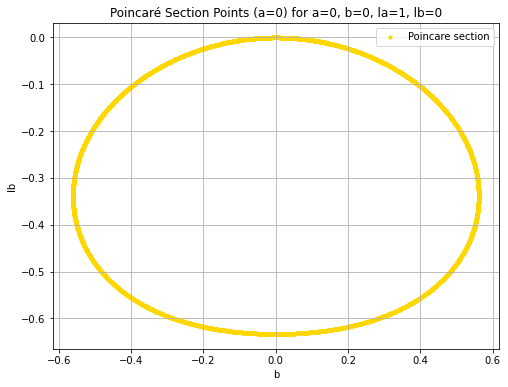

In [75]:
do_the_thing(0, 0, 1, 0)

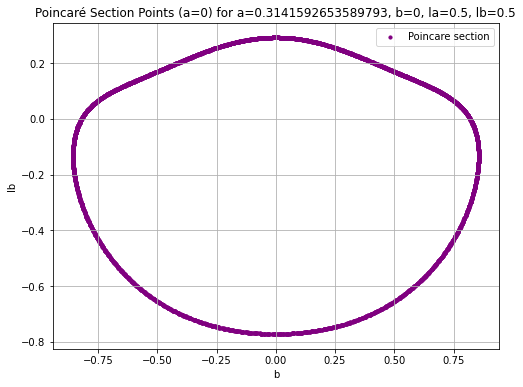

In [111]:
do_the_thing(0.1 * math.pi, 0, 0.5, 0.5)

Если отношение частот рационально получаем резонанс. На графике нексолько скоплений точек вместо почти непрерывной траектории, так как система периодически проходит через них.

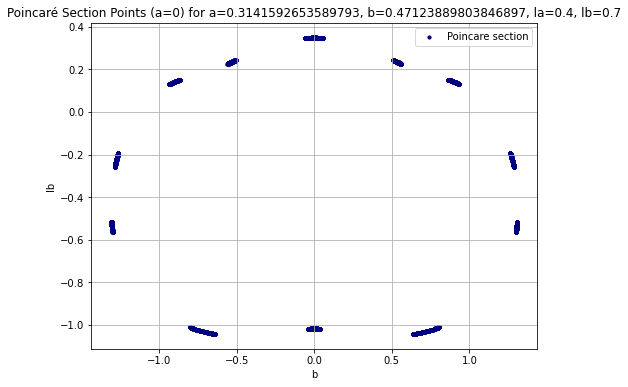

In [80]:
do_the_thing(0.1 * math.pi, 0.15 * math.pi, 0.4, 0.7)

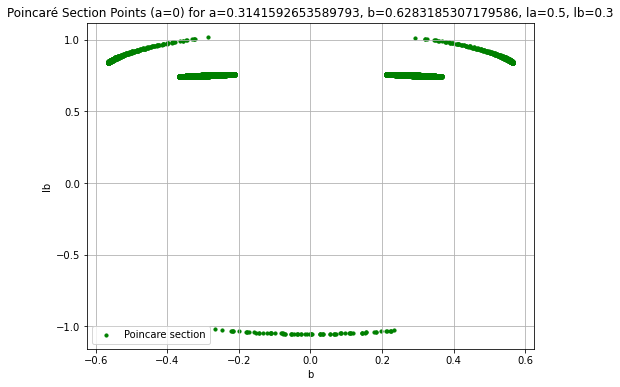

In [113]:
do_the_thing(0.1 * math.pi, 0.2 * math.pi, 0.5, 0.3)

Если мы будем недалеко от резонансного случая, то будет так называемый нелинейный резонанс: отношение частот иррационально, но траектории почти повторяют себя и получются n циклов около периодических точек. 

Тракетория проходит через все циклы перед тем как вернуться к первому.

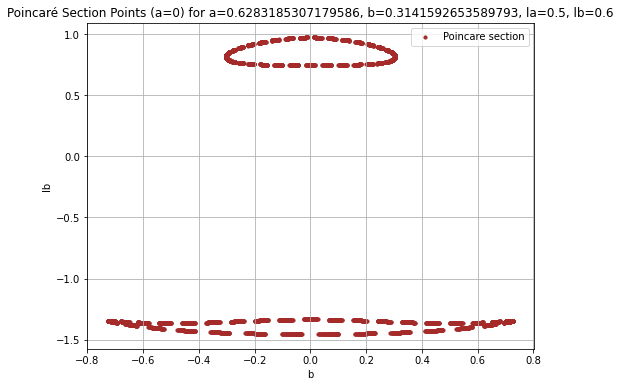

In [132]:
do_the_thing(0.2 * math.pi, 0.1 * math.pi, 0.5, 0.6)

Если при больших энергиях сильно отходить от рационального отношения частот, то будет хаос. 

Около квазипериодических орбит будут появляться нелинейные резонансы и в итоге получим фрактальное поведение и в конце концов довольно хаотическое поведение.

В случае хаоса траектория не является какой-либо кривой, а проходит через весь объём рассмариваемого куска пространства.

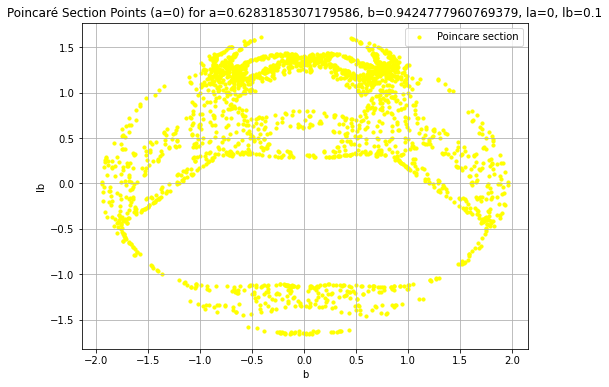

In [108]:
do_the_thing(0.2 * math.pi, 0.3 * math.pi, 0, 0.1)

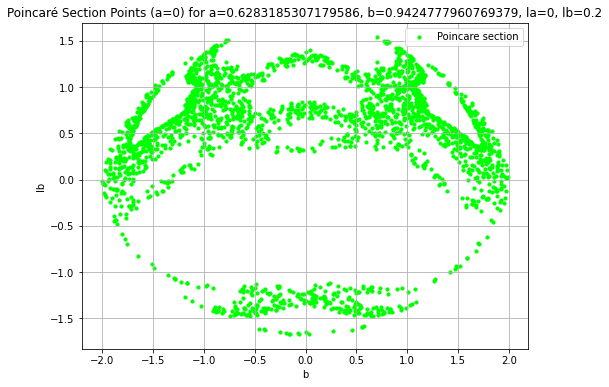

In [69]:
do_the_thing(0.2 * math.pi, 0.3 * math.pi, 0, 0.2)

В этом и заключается парадокс двойного маятника: при некоторых начальных условиях наблюдается хаотическое поведение, несмотря на детерминированность формул.